In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, date
from datetime import datetime
import statsmodels.api as sm
import math

raw_data = pd.read_csv('time_series_covid19_confirmed_global.csv')

## change column dates to the correct date format
def standarlize_dates_from_column_headers(column_headers):
    first_date_position = 4
    first_date = column_headers[first_date_position]
    
    column_headers_new = []
    for header in column_headers[:first_date_position]:
        header_new = header
        column_headers_new.append(header_new)

    try:
        first_date = datetime.strptime(first_date, '%m/%d/%y')
        column_headers_new.append(first_date)
    except:
        print('fisrt date format is wrong')

    count = 0
    for header in column_headers[first_date_position + 1:]:
        count = count + 1
        header_new = first_date + timedelta(days=count)

        column_headers_new.append(header_new)
    return column_headers_new

column_headers = standarlize_dates_from_column_headers(raw_data.columns)
raw_data.columns = column_headers

In [3]:
class GetCountryData:
    def __init__(self, df, country_name):
        self.country_name = country_name
        self.df = df
    
    ## create the date index for dataset
    def create_index(self):
        df = self.df
        first_date = df.columns[4]
        last_date = df.columns[-1]
        date_list = []
        for day_count in range((last_date - first_date).days+1):
            date_list.append(first_date + timedelta(day_count))
        return date_list

    def data(self):
        index = self.create_index()
        ## extract the data of a specific country from dataset
        ## and transform the data into a ideal format
        df = self.df
        df = df.loc[df['Country/Region'] == self.country_name]
        df = df.drop(df.columns[[0, 2, 3]], axis=1)
        df = df.groupby(['Country/Region'], as_index=False).sum()
        df = df.set_index('Country/Region').T
        df = pd.DataFrame({'Confirmed_Cases':[x for x in df[self.country_name]]})
        df['Date'] = index
        return df.set_index('Date')

## period date after 01, March might be more representative 
choose_time = datetime.strptime('03/01/20', '%m/%d/%y')
df_new = GetCountryData(raw_data, 'Canada').data()
df = df_new.loc[df_new.index > choose_time]

## convert data into log
## test the stationarity of both original data and log data with and without differencing
df_log = df.apply(lambda x: math.log(x), axis=1)
df_log = pd.DataFrame({'Confirmed_Cases':[x for x in df_log]})
index_new = [x for x in df_new.index if x > choose_time]

df_log['Date'] = index_new
df_log = df_log.set_index('Date')

In [4]:
class TestData:
    def __init__(self, df):
        self.df = df

    def visualize(self):
        df = self.df
        plt.figure(figsize=(15,6))
        plt.plot(df)

    def ACF_PACF(self, string):
        df = self.df
        lag = 30
        if string == 'non_diff':
            fig, ax = plt.subplots(2,1,figsize=(20,10))
            fig = sm.graphics.tsa.plot_acf(df, lags=lag, ax=ax[0])
            fig = sm.graphics.tsa.plot_pacf(df, lags=lag, ax=ax[1])
        if string == 'diff':
            fig, ax = plt.subplots(2,1,figsize=(20,10))
            fig = sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=lag, ax=ax[0])
            fig = sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=lag, ax=ax[1])
    
    def ADF_test(self):
        df = self.df
        adf = sm.tsa.adfuller(df.iloc[:, 0],regression='ct')
        adf_diff = sm.tsa.adfuller(df.iloc[:, 0].diff().dropna(),regression='ct')
        return {'p_value original data': adf[1], 'p_value differencing data' : adf_diff[1]}

test = TestData(df)
test_log = TestData(df_log)

## results show that only the original data has the stationarity
## the p value for Augmented Dickey Fuller test is significant
print('no_log:', test.ADF_test())
print('log:', test_log.ADF_test())
## ----->'non_log: {'p_value original data': 0.0002307253080606272, 'p_value differencing data': 0.24258926046962087}'
## ----->'log: {'p_value original data': 1.0, 'p_value differencing data': 0.786278349891531}'

no_log: {'p_value original data': 0.00023072530806061617, 'p_value differencing data': 0.24258926046961965}
log: {'p_value original data': 1.0, 'p_value differencing data': 0.7862783498915058}


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


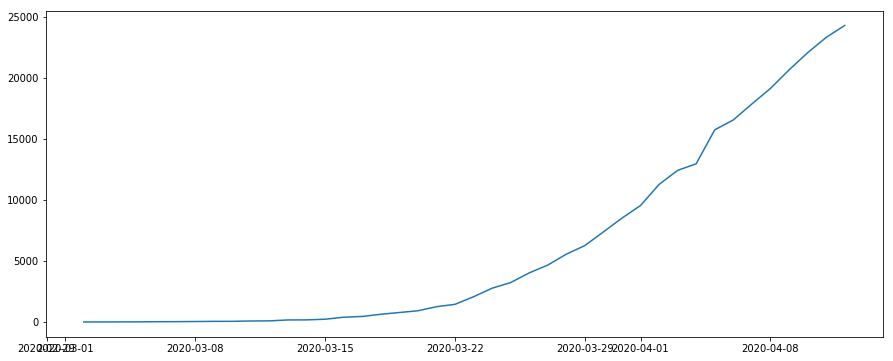

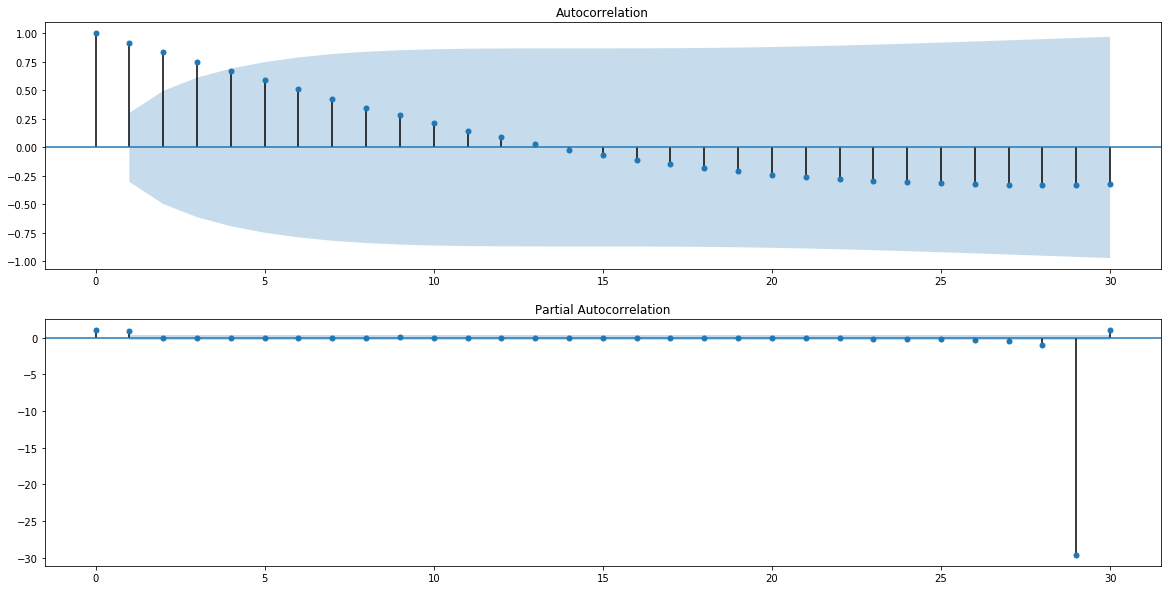

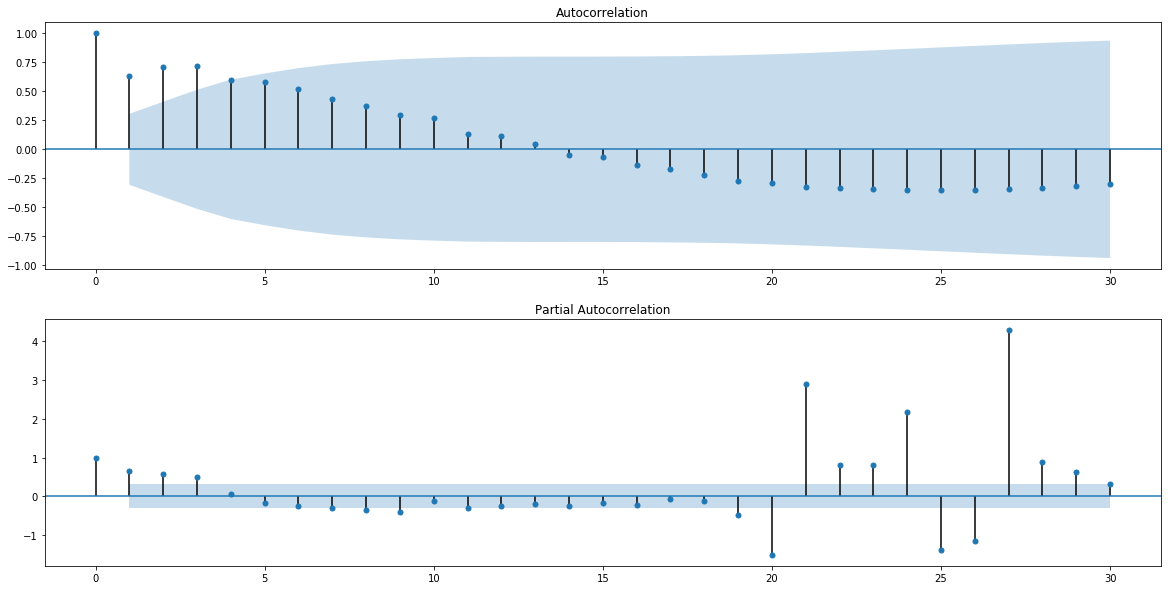

In [5]:
test.visualize()
test.ACF_PACF('non_diff')
test.ACF_PACF('diff')
## by looking at the graph, ARMIA(2, 5) might be used

In [7]:
class DataSplit(TestData):
    def __init__(self, df):
        super().__init__(df)

    def split(self):
        df = self.df
        train_n = round(len(df) * 0.8)
        train = df[:train_n - 1]
        test = df[train_n - 1 :]
        return (train, test)

    def split_data(self, string):
        if string == 'original':
            df = self.df
            return self.split()

        elif string == 'diff':
            df = self.df.diff().dropna()
            return self.split()

## data without log and differencing
train, test = DataSplit(df).split_data('original')
# train_dif, test_dif = transform_data(df).split_data('diff')
print(test)

Confirmed_Cases
Date                       
2020-04-04            12978
2020-04-05            15756
2020-04-06            16563
2020-04-07            17872
2020-04-08            19141
2020-04-09            20654
2020-04-10            22059
2020-04-11            23316
2020-04-12            24298


In [56]:
import warnings
import itertools
from collections.abc import Iterable

class GetModel:
    def __init__(self, train):
        self.train = train
        
    def seasonal_params(self, p, d, q, s):
        p = range(0, p+1)
        q = range(0, q+1)
        d = [d]
        PDQs = list(itertools.product(p, d, q))
        seasonal_PDQs = [(x[0], x[1], x[2], s) for x in list(PDQs)]
        return (PDQs, seasonal_PDQs)
    
    def find_lowest_aic(self, results):
        
        lowest_value = 0
        
        for key, value in results.items():
            if lowest_value == 0:
                lowest_value = lowest_value + value
            if value < lowest_value:
                lowest_value = value
                key_new = key

        lowest_aic_combination = 'Best combination: {} with minimum AIC {}'.format(key_new, lowest_value)

        return lowest_aic_combination

    def model_fit(self, train, param, param_seasonal, show):
        mod = sm.tsa.statespace.SARIMAX(train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        result = mod.fit()

        if show == True:
            result.plot_diagnostics(figsize=(15, 12))
            plt.show()

        return result

    def params_iteration_results(self, p, d, q, s, season=False):
        train = self.train
        PDQs, seasonal_PDQs = self.seasonal_params(p, d, q, s)
        results = {}
        show = False

        warnings.filterwarnings("ignore")
        
        param_seasonal = (0, 0, 0, 0)
        for param in PDQs:
            try:
                result = self.model_fit(train, param, param_seasonal, show)
                results['ARIMA{}x{}'.format(param, param_seasonal)] = result.aic
            except:
                continue

        if season:
            for param in PDQs:
                for param_seasonal in seasonal_PDQs:
                    try:
                        result = self.model_fit(train, param, param_seasonal, show)
                        results['ARIMA{}x{}'.format(param, param_seasonal)] = result.aic
                    except:
                        continue
        
        lowest_aic_combination = self.find_lowest_aic(results)

        return lowest_aic_combination

    def arima(self, p, d, q, s, show=False):
        train = self.train
        param = (p, d, q, s)
        param_seasonal = (0, 0, 0, 0)

        result = self.model_fit(train, param, param_seasonal, show)

        return result
    
    def sarima(self, p, d, q, s, *args, show=False):
        train = self.train
        param = (p, d, q, s)
        param_seasonal = (args)

        result = self.model_fit(train, param, param_seasonal, show)

        return result

model = GetModel(train)

In [58]:
p = 6
d = 2
q = 6
s = 0
## since I don't think there would be a seasonal effect, so I put s = 0
## run different combinations of parameters
## the initial guess is AR(2), MA(5), but let's try more combinations, and with differencing
print(model.params_iteration_results(p, d, q, s))

Best combination: ARIMA(3, 2, 6)x(0, 0, 0, 0) with minimum AIC 316.9636931942053


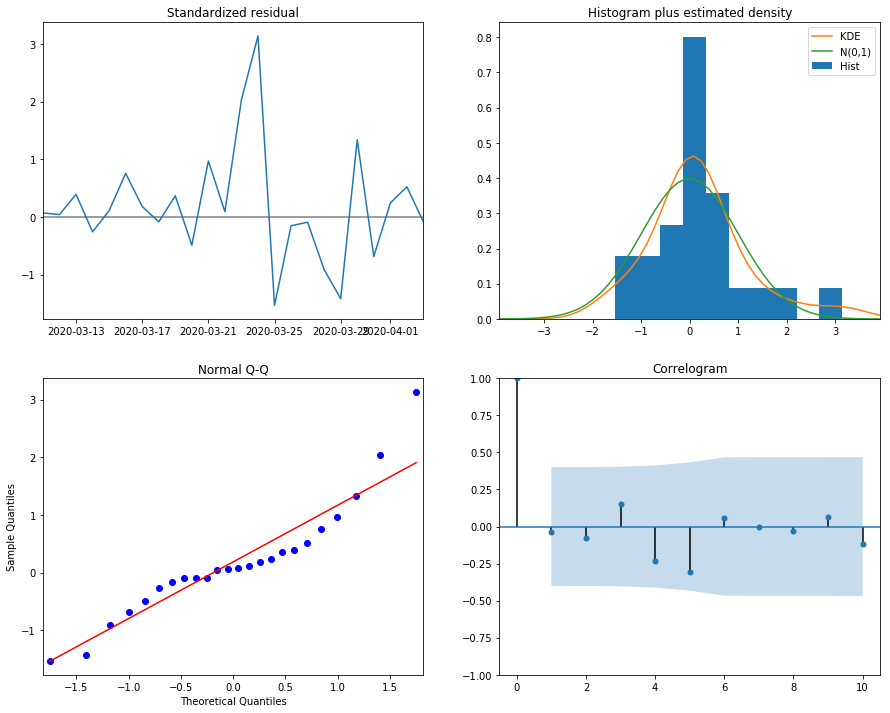

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        Confirmed_Cases   No. Observations:                   33
Model:               SARIMAX(3, 2, 6)   Log Likelihood                -148.482
Date:                Sun, 19 Apr 2020   AIC                            316.964
Time:                        23:58:11   BIC                            328.744
Sample:                    03-02-2020   HQIC                           320.089
                         - 04-03-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8680      0.442     -1.962      0.050      -1.735      -0.001
ar.L2          0.8820      0.422      2.091      0.036       0.055       1.709
ar.L3          1.3932      0.240      5.799      0.000       0.922       1.864
ma.L1          0.1503     71.431      0.002      0.998    -139.851     140.152
ma.L2         -1.3422     77.100     -0.017      0.986    -152.455     149.770
ma.L3         -0.3441     16.751     -0.021      0.984     -33.175      32.487
ma.L4          0.6763     34.773      0.019      0.984     -67.477      68.830
ma.L5         -0.0669      9.666     -0.007      0.994     -19.013      18.879
ma.L6         -0.0712      5.278     -0.013      0.989     -10.416      10.274
sigma2      1.134e+04   7.49e+05      0.015      0.988   -1.46e+06    1.48e+06
===================================================================================
Ljung-Box (Q):                        7.97   Jarque-Bera (JB):                 7.15
Prob(Q):                              1.00   Prob(JB):                         0.03
Heteroskedasticity (H):               6.45   Skew:                             0.98
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.86e+14. Standard errors may be unstable.
"""

In [66]:
## AR lags are quite significant but MA lags are not significant 
## and the residual is not close to white noise
## that means there are other information that are contained in the error term
## and I couldn't find other exogenous variables data
p = 3
d = 2
q = 6
s = 0
model.arima(p, d, q, s, show=True).summary()

In [67]:
p = 3
d = 2
q = 6
s = 0
results = GetModel(df).arima(p, d, q, s)

## get and plot forecast results
class ForecastResults:
    def __init__(self, results, df, test):
        self.df = df
        self.results = results
        self.test_start_date = test.index[0]
        self.begin_date = df.index[0]
        self.end_date = df.index[-1]
        self.test = test
    
    def rmse_calculation(self, y_forecasted):
        y_truth = self.test
        mse = [(x - y)**2 for (x, y) in zip(y_forecasted, y_truth.iloc[:, 0])]
        rmse = math.sqrt(sum(mse)/len(mse))
        return rmse

    def result_plot(self, pred, df_for_plot, step_ahead_forecast=False):
        pred_confidence = pred.conf_int()## get confidence level

        ax = df_for_plot[self.begin_date:].plot(label='observed', figsize=(10, 6))
        pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.5)

        ax.fill_between(pred_confidence.index,
                        pred_confidence.iloc[:, 0],
                        pred_confidence.iloc[:, 1], color='k', alpha=.2)
        
        if step_ahead_forecast == False:
            ax.fill_betweenx(ax.get_ylim(), self.test_start_date, self.end_date,
                    alpha=.1, zorder=-1)
        
        ax.set_xlabel('Date')
        ax.set_ylabel('Confirmed Cases')
        plt.title('Canada COVID 19')

        plt.legend()
        plt.show()

    def nondynamic_forecast(self):
        ## dynamic=False, each point is generated by using the full history up to that point
        pred_nondynamic = self.results.get_prediction(start=self.test_start_date)
        y_forecasted_nondynamic = pred_nondynamic.predicted_mean

        self.result_plot(pred_nondynamic, self.df)

        rmse_nondynamic = self.rmse_calculation(y_forecasted_nondynamic)

        return 'Root Mean Square Error : {}'.format(round(rmse_nondynamic, 2))
    
    def dynamic_forecast(self):
        ## dynamic=True, forecasting points are generated by using previous forecasting points
        pred_dynamic = self.results.get_prediction(start=self.test_start_date, dynamic=True, full_results=True)
        y_forecasted_dynamic = pred_dynamic.predicted_mean

        self.result_plot(pred_dynamic, self.df)

        rmse_dynamic = self.rmse_calculation(y_forecasted_dynamic)

        return 'dynamic forecast Root Mean Square Error : {}'.format(round(rmse_dynamic, 2))
    
    def contact_dataframe(self, y_forecasted_step_ahead):
        ## add the first observation from forecast result to original data
        ## in order to connect the original and forecast data in the plot
        new_row_column_title = self.df.columns[0]
        new_row_data = y_forecasted_step_ahead[0]
        new_row_with_column_title = {new_row_column_title: new_row_data}

        new_row_time_index = [y_forecasted_step_ahead.index[0]]
        new_row = pd.DataFrame(data=new_row_with_column_title, index=new_row_time_index)
        df_contacted = pd.concat([self.df, new_row])

        return df_contacted

    def step_ahead_forecast(self, steps_ahead):

        steps_ahead = steps_ahead
        pred_step_ahead = self.results.get_forecast(steps=steps_ahead)
        y_forecasted_step_ahead = pred_step_ahead.predicted_mean

        df_contacted = self.contact_dataframe(y_forecasted_step_ahead)
       
        self.result_plot(pred_step_ahead, df_contacted, step_ahead_forecast=True)

        return y_forecasted_step_ahead

forecast = ForecastResults(results, df, test)


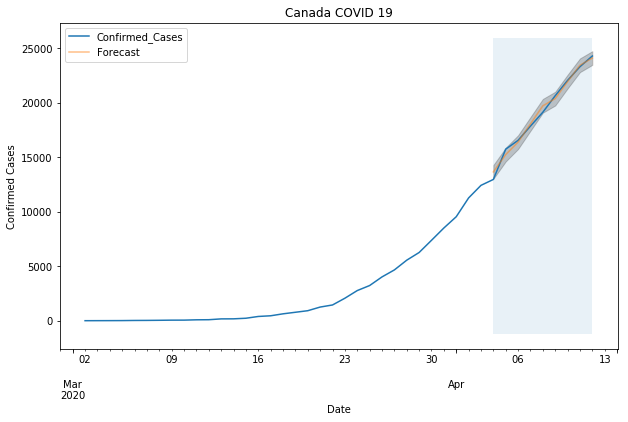

Root Mean Square Error : 375.31


In [68]:
nondynamic_forecast = forecast.nondynamic_forecast()
print(nondynamic_forecast)

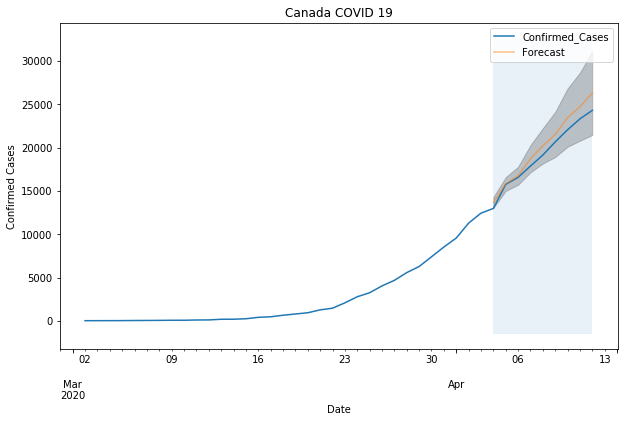

dynamic forecast Root Mean Square Error : 1105.99


In [69]:
dynamic_forecast = forecast.dynamic_forecast()
print(dynamic_forecast)

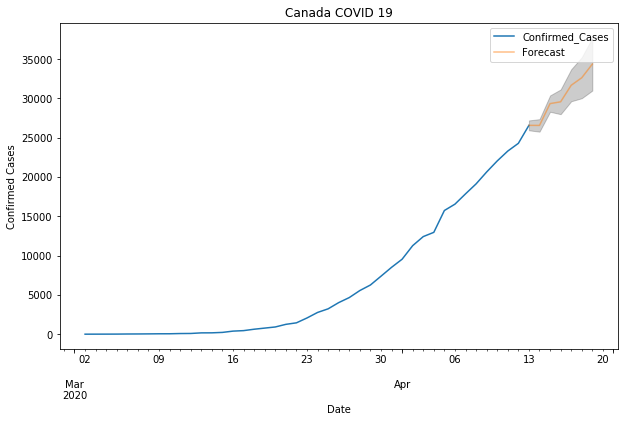

2020-04-13    26584.583026
2020-04-14    26577.295739
2020-04-15    29351.444659
2020-04-16    29579.057012
2020-04-17    31682.313164
2020-04-18    32640.448848
2020-04-19    34373.450238
Freq: D, dtype: float64


In [70]:
steps_ahead = 7
step_ahead_forecast = forecast.step_ahead_forecast(steps_ahead)
print(step_ahead_forecast)

In [65]:
## conclusion: since the period is really short,
## and I couldn't find exogenous variables and have them included in the model,
## I think the forecasting result is highly dependent on most recent data,
## which means we need always update the data,
## and the model is only capable of predicting cases in short period 